<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [2]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [3]:
from bs4 import BeautifulSoup
import requests

data = "./data/job_listings.csv"

df = pd.read_csv(data)
print(df.shape)
df.head()


(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [4]:
def clean_description(description):
    
    soup = BeautifulSoup(description, 'html.parser')
    
    return soup.get_text()

In [5]:
df['description'] = df['description'].apply(clean_description)
print(df.shape)
df.head()

(426, 3)


,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [6]:
# create a tokenizing function with spacy

# set nlp equal to the trained vocabulary model
nlp = spacy.load('en_core_web_lg')

def tokenize(description):
    
    doc = nlp(description)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) & (token.is_punct != True) & (token.like_num != True)]


In [7]:
# test the tokenizing function on one description
tokenize(df['description'][0])

['b"Job',
 'requirements:\\nconceptual',
 'understanding',
 'Machine',
 'Learning',
 'model',
 'like',
 'nai\\xc2\\xa8ve',
 'Bayes',
 'K',
 'Means',
 'SVM',
 'Apriori',
 'Linear/',
 'Logistic',
 'Regression',
 'neural',
 'Random',
 'Forests',
 'decision',
 'Trees',
 'K',
 'NN',
 'hand',
 'experience',
 'them\\nintermediate',
 'expert',
 'level',
 'coding',
 'skill',
 'Python',
 'R.',
 'ability',
 'write',
 'function',
 'clean',
 'efficient',
 'datum',
 'manipulation',
 'mandatory',
 'role)\\nexposure',
 'package',
 'like',
 'NumPy',
 'SciPy',
 'Pandas',
 'Matplotlib',
 'etc',
 'Python',
 'GGPlot2',
 'dplyr',
 'tidyR',
 'R\\nAbility',
 'communicate',
 'Model',
 'finding',
 'Technical',
 'Non',
 'technical',
 'stake',
 'holders\\nhand',
 'experience',
 'SQL',
 'Hive',
 'similar',
 'programming',
 'language\\nmust',
 'past',
 'work',
 'GitHub',
 'Kaggle',
 'publish',
 'article\\nmaster',
 'degree',
 'Statistics',
 'Mathematics',
 'Computer',
 'Science',
 'quant',
 'specific',
 'field.\\na

In [8]:
# apply the tokenizing function across all descriptions
df['tokenized_description'] = df['description'].apply(tokenize)

In [10]:
# inspect the dataframe. make sure dimensions remained. 
print(df.shape)
df.head()

(426, 4)


,Unnamed: 0,description,title,tokenized_description
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, hel..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines..."
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, monthcontractunder, general, sup..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [11]:
# instantiate the CountVectorizer
vect = CountVectorizer(tokenizer=tokenize, max_features=1000, strip_accents='ascii')

# fit the vector to our Vocab (data)
vect.fit(df['description'])

# get sparse Document Term Matrices (DTM)
dtm = vect.transform(df['description'])

/home/tmbern/workspace/res/miniconda3/envs/Unit4-Sprint1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [12]:
# what is the shape of the Matrices
dtm.todense().shape

(426, 1000)

In [13]:
# what are some of the features

vect.get_feature_names()

['$',
 '+',
 '\\xe2\\x80\\x93',
 '\\xe2\\x80\\x94',
 'ability',
 'able',
 'academic',
 'accelerate',
 'accept',
 'access',
 'accommodation',
 'account',
 'accuracy',
 'accurate',
 'achieve',
 'acquisition',
 'act',
 'action',
 'actionable',
 'activity',
 'ad',
 'add',
 'addition',
 'additional',
 'address',
 'adoption',
 'advance',
 'advanced',
 'advantage',
 'advertising',
 'affirmative',
 'age',
 'agency',
 'agile',
 'ai',
 'aim',
 'algorithm',
 'algorithmic',
 'allow',
 'alongside',
 'amazon',
 'americas',
 'amount',
 'analysis',
 'analyst',
 'analytic',
 'analytical',
 'analytics',
 'analyze',
 'ancestry',
 'and/or',
 'anomaly',
 'answer',
 'app',
 'applicable',
 'applicant',
 'application',
 'applied',
 'apply',
 'approach',
 'appropriate',
 'architect',
 'architecture',
 'area',
 'art',
 'articulate',
 'artificial',
 'ask',
 'aspect',
 'assess',
 'asset',
 'assign',
 'assist',
 'assistance',
 'associate',
 'attention',
 'audience',
 'autodesk',
 'automate',
 'automation',
 'avail

In [14]:
dtm_df = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm_df.head()

,$,+,\xe2\x80\x93,\xe2\x80\x94,ability,able,academic,accelerate,accept,access,...,world\xe2\x80\x99s,worldwide,write,writing,year,years\xe2\x80\x99,york,you\'ll,you\xe2\x80\x99ll,||
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
count_df = pd.DataFrame(dtm.sum(axis=0), columns=vect.get_feature_names())
count_df = count_df.T.sort_values(by=0, ascending=False)
count_df

,0
datum,2934
work,1369
data,1270
team,1199
business,1171
...,...
price,20
interface,19
dedicate,19
ask,19


## 4) Visualize the most common word counts

In [16]:
top15 = count_df.reset_index()[1:15]

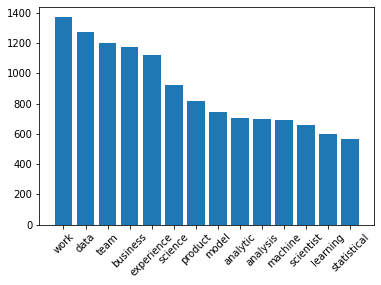

In [17]:
plt.bar(x=top15['index'], height=top15[0])
plt.xticks(rotation=45)
plt.show()

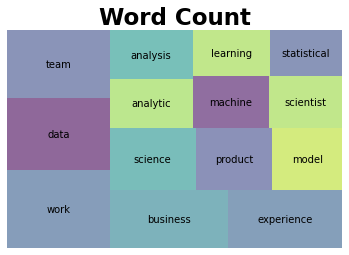

In [18]:
import squarify

squarify.plot(label=top15['index'],sizes=top15[0], alpha=.6)
plt.title("Word Count",fontsize=23,fontweight="bold")

plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [23]:
# Instatiate vectorizer object

tfidf = TfidfVectorizer(ngram_range=(1,3),
                        tokenizer=tokenize,
                        max_df=.97,
                        min_df=.05
                        )

# fit_transform to the covabulary and data.
dtm = tfidf.fit_transform(df['description'])

In [26]:
dtm.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.04201787, 0.04556909, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.07848864, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [27]:
dtm_tfidf_df = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
print(dtm_tfidf_df.shape)
dtm_tfidf_df.head()

(426, 1102)


,$,+,+ year,+ year experience,\xe2\x80\x93,ability,ability work,able,academic,accelerate,...,write verbal,write verbal communication,year,year experience,year professional,year relevant,year work,years\xe2\x80\x99,york,you\xe2\x80\x99ll
0,0.000000,0.000000,0.000000,0.0,0.000000,0.082300,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.042018,0.045569,0.0,0.000000,0.038522,0.0,0.0,0.0,0.0,...,0.0,0.0,0.030152,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.252208,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.036075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.227492,0.246719,0.0,0.331556,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.163249,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [28]:
from sklearn.neighbors import NearestNeighbors

# Fit the NearestNeighbors on Document Term Matrice
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm_tfidf_df)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [29]:
nn.kneighbors()

(array([[1.20109877, 1.20415807, 1.22038335, 1.23723454, 1.24059547],
        [1.15115574, 1.15436533, 1.15877309, 1.15937587, 1.1606522 ],
        [1.17620968, 1.19486614, 1.20061477, 1.21418896, 1.22138758],
        ...,
        [0.        , 1.16996466, 1.17088523, 1.17294658, 1.17294658],
        [0.        , 1.11440284, 1.12040706, 1.14259902, 1.14313315],
        [1.11007774, 1.12610548, 1.14123854, 1.14782574, 1.15838702]]),
 array([[403,  79, 327, 338, 222],
        [136, 331, 201, 285, 222],
        [307, 190,  51, 318, 331],
        ...,
        [ 44, 363, 244, 110, 132],
        [382, 201, 399, 162, 283],
        [213, 201, 383, 388, 406]]))

In [30]:
# write description for ideal datascience job

job_desc = ["""

Brighthouse Financial is on a mission to help people achieve financial security. As one of the largest providers of annuities and life insurance in the U.S., we specialize in products designed to help people protect what they've earned and ensure it lasts. We are built on a foundation of experience and knowledge, which allows us to keep our promises and provide the value they deserve.

At Brighthouse Financial, we're fostering a culture where diverse backgrounds and experiences are celebrated, and different ideas are heard and respected. We believe that by creating an inclusive workplace, we're better able to attract and retain our talent, provide valuable solutions that meet the needs of our advisors and their clients, and deliver on our mission of helping more people achieve financial security. We're se eking passionate, high-performing team member to join us. Sound like you? Read on.

How This Role Contributes to Brighthouse Financial:

Data Scientists in Brighthouse Financial's Data Science organization work closely with cross-functional teams in marketing, distribution, actuarial, product and other functions, leveraging Brighthouse Financial's rich datasets to develop and deliver propensity models and data-driven insights, and ultimately drive Brighthouse Financial's top line growth. A successful candidate will be passionate about finding insights in data and using quantitative analysis to answer complex questions, with a collaborative and resourceful style.

Key Responsibilities:
Conduct data analytics with the relevant programming / statistical package (such as R or Python) for large-scale problem solving
Work independently and possesses exceptional technical ability.
Understand complex business challenges, develop hypotheses, convert into the right analytical hypothesis, and communicate the results back to the partner teams with limited or no analytical background to drive the business strategy
Analyze internal / external, online / offline, and structured / unstructured data such as speech analytics, digital footprints, financial information, proprietary market research and secondary sources to identify insights
Create innovative solutions to business problems.
Partner with other operational areas to identify opportunities for new projects.
Build strong working relationships and improve workflow and organizational issues.
Build complex advanced-level machine learning and advanced analytics models.
Handle and resolve questions and issues referred by junior staff members.
May propose, evaluate and implement process improvements to increase efficiency and effectiveness.
Perform other duties as required or assigned.



Essential Business Experience and Technical Skills:
Doctoral degree in a technical field and two plus years of related work experience, or a Master's degree in a technical field and at least 3-4 years of related work experience, or a Bachelor's degree in a technical field and at least 6-8 years of related work experience.
Significant professional experience required applying quantitative analysis and modeling to solving real-world business problems including experience in model validation, testing and deployment
Demonstrated proficiency in Python/PySpark required
Demonstrated ability to perform high quality work independently
Excellent oral and written communication skills, including the ability to explain complicated quantitative concepts to non-technical stakeholders using effective story telling techniques and visualization
Ability to translate business requirements into detailed analysis plans.
Ability to prioritize requests to meet the most important and urgent business needs
Working knowledge of insurance industry is a plus
Prior exposure to financial services or insurance industry preferred

"""]

In [31]:
# transform on the new job desc with the fit tfidf model

new_job = tfidf.transform(job_desc)

In [32]:
# what does the new job look like
new_job

<1x1102 sparse matrix of type '<class 'numpy.float64'>'
	with 215 stored elements in Compressed Sparse Row format>

In [33]:
# get the 5 most nearest neighbors to this new_job
nn.kneighbors(new_job.todense())

(array([[1.11024124, 1.12694256, 1.12698366, 1.13459815, 1.13491203]]),
 array([[408,  36, 331, 208, 271]]))

In [34]:
# inspect some of these descriptions to see how closely the match the new job description
df['description'][408]

"b'FinLocker is a leading financial data and analytics company. We focus on analyzing consumer financial data such as assets, income, employment, taxes, credit, liabilities, real estate and more. You will be responsible for designing and implementing the models and analyses for the function of a \\xe2\\x80\\x9cvirtual financial advisor\\xe2\\x80\\x9d for the consumer.\\nOur office is located in Clayton, MO with remote employees throughout the US.\\n\\nThis is a full-time position that will be based in our Clayton (St. Louis) office.\\n\\nSalary is competitive to relevant experience.\\n\\nKey Qualifications:\\n\\n6+ years\\xe2\\x80\\x99 experience of applying machine learning techniques, optimization, and statistics to drive key decisions\\nExtensive hands-on experience with development of predictive models and machine learning/AI-based solutions\\nSolid programming skills in Python, R or similar data science language\\nAdvanced proficiency in data visualization\\nPrefer financial servi

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 

In [35]:
df.head()

,Unnamed: 0,description,title,tokenized_description
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, hel..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines..."
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, monthcontractunder, general, sup..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."


In [36]:
df.title.value_counts()



Data Scientist                                                                     150
Senior Data Scientist                                                               14
Junior Data Scientist                                                               10
Associate Data Scientist                                                             8
Data Scientist Intern                                                                7
                                                                                  ... 
Data Scientist, Infrastructure                                                       1
Data Scientist, Analytics                                                            1
Data Scientist Summer Internship                                                     1
2019 PhD University Graduate - Data Scientist I/II - Applied Behavioral Science      1
Data Scientist Summer Intern                                                         1
Name: title, Length: 177, dtype: int64

In [49]:
df.title.str.contains('data ana', case=False).value_counts()

False    419
True       7
Name: title, dtype: int64

In [51]:
df_analyst = df[df.title.str.contains('data ana', case=False) == True]
df_analyst

,Unnamed: 0,description,title,tokenized_description
19,19,"b'$70,000 - $100,000 a yearTitle: Data Analyst...",Data Analyst/Jr. Data Scientist,"[b'$70,000, $, yeartitle, Data, Analyst, Jr, D..."
35,35,"b'Temporary, InternshipMongoDB is seeking a hi...",Data Scientist/Data Analytics Intern - Summer ...,"[b'Temporary, InternshipMongoDB, seek, highly,..."
141,141,"b""About the Role\nBabylist is looking for a Da...",Data Analyst,"[b""about, Role\nBabylist, look, Data, Analyst,..."
220,220,"b'$78,600 a yearJob Description\n\nData Analyt...",Data Analytics Consultant,"[b'$78,600, yearJob, Description\n\nData, Anal..."
287,287,"b"":Who We Are: SixLeaf is THE leading marketin...",Data Analyst / Data Scientist,"[b"":Who, sixleaf, lead, marketing, platform, p..."
323,323,"b""About the Role\nBabylist is looking for a Da...",Data Analyst,"[b""about, Role\nBabylist, look, Data, Analyst,..."
417,417,b'About the Role...\n\nLogic2020 is looking to...,Data Analyst / Jr. Data Scientist,"[b'About, role, \n\nlogic2020, look, secure, D..."


In [53]:
df_scientist = df[df.title.str.contains('data ana', case=False) == False]
df_scientist

,Unnamed: 0,description,title,tokenized_description
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, hel..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines..."
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, monthcontractunder, general, sup..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."
...,...,...,...,...
421,421,"b""About Us:\nWant to be part of a fantastic an...",Senior Data Science Engineer,"[b""About, Us:\nWant, fantastic, fun, startup, ..."
422,422,"b'InternshipAt Uber, we ignite opportunity by ...",2019 PhD Data Scientist Internship - Forecasti...,"[b'InternshipAt, Uber, ignite, opportunity, se..."
423,423,"b'$200,000 - $350,000 a yearA million people a...",Data Scientist - Insurance,"[b'$200,000, $, yearA, people, year, die, car,..."
424,424,"b""SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nAB...",Senior Data Scientist,"[b""SENIOR, DATA, SCIENTIST\nJOB, description\n..."


## Job descriptions with title of Data Analyst

In [61]:
# for the data analyst position

# instantiate the CountVectorizer
vect = CountVectorizer(tokenizer=tokenize, max_features=1000, strip_accents='ascii')

# fit the vector to our Vocab (data)
vect.fit(df_analyst['description'])

# get sparse Document Term Matrices (DTM)
dtm = vect.transform(df_analyst['description'])

/home/tmbern/workspace/res/miniconda3/envs/Unit4-Sprint1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [63]:
dtm.todense()

matrix([[2, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        [1, 1, 0, ..., 0, 2, 1],
        ...,
        [0, 0, 0, ..., 0, 3, 1],
        [1, 1, 0, ..., 0, 2, 1],
        [0, 2, 0, ..., 0, 0, 0]])

In [64]:
count_analyst_df = pd.DataFrame(dtm.todense().sum(axis=0), columns=vect.get_feature_names())
count_analyst_df = count_analyst_df.T.sort_values(by=0, ascending=False)
count_analyst_df

,0
datum,35
business,32
data,31
work,30
team,16
...,...
bit,1
past,1
bluntly,1
boundaries\n\n,1


In [72]:
top15 = count_analyst_df.reset_index()[0:15]

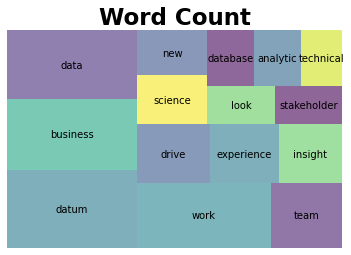

In [73]:
squarify.plot(label=top15['index'],sizes=top15[0], alpha=.6)
plt.title("Word Count",fontsize=23,fontweight="bold")

plt.axis('off')
plt.show()

## Job descriptions with title of Data Scientist

In [65]:
# for the data scientist position

# instantiate the CountVectorizer
vect = CountVectorizer(tokenizer=tokenize, max_features=1000, strip_accents='ascii')

# fit the vector to our Vocab (data)
vect.fit(df_scientist['description'])

# get sparse Document Term Matrices (DTM)
dtm = vect.transform(df_scientist['description'])

/home/tmbern/workspace/res/miniconda3/envs/Unit4-Sprint1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [68]:
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0]])

In [69]:
count_scientist_df = pd.DataFrame(dtm.todense().sum(axis=0), columns=vect.get_feature_names())
count_scientist_df = count_scientist_df.T.sort_values(by=0, ascending=False)
count_scientist_df

,0
datum,2899
work,1339
data,1239
team,1183
business,1139
...,...
signal,19
talk,19
geospatial,19
git,19


In [74]:
top15 = count_scientist_df.reset_index()[0:15]

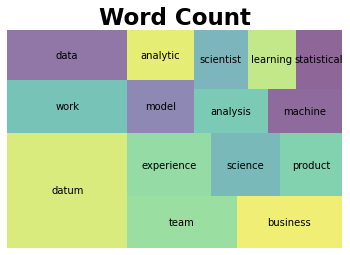

In [75]:
squarify.plot(label=top15['index'],sizes=top15[0], alpha=.6)
plt.title("Word Count",fontsize=23,fontweight="bold")

plt.axis('off')
plt.show()

In [58]:
nlp.Defaults.stop_words.union

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']

In [60]:
count_df[:30]

,0
datum,2934
work,1369
data,1270
team,1199
business,1171
experience,1123
science,924
product,820
model,747
analytic,705
